# Physical Risk Impact Model with Supply Chain Reallocation

The present notebook is an application of the model described in _Fahr 2024_, which computes the amplified impact of climate-related physical risk through Input-Output linkages, implementing a trade reallocation mechanism

#### Basic setup

In [1]:
# Physical Risk Propagation Model - main.ipynb
# 
# Orchestrates:
#  - Loading latest EU-27 SAM from Databricks
#  - Initialising IOClimateModel
#  - Running physical risk propagation until convergence
#  - Inspecting and exporting results

import os
import sys

# If notebook is at project/main.ipynb and src/ is project/src/
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd()))
SRC_DIR = os.path.join(PROJECT_ROOT, "src")

if SRC_DIR not in sys.path:
    sys.path.append(SRC_DIR)

# Standard libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Spark (in Databricks, `spark` is usually already defined)
try:
    spark
except NameError:
    from pyspark.sql import SparkSession
    spark = SparkSession.builder.appName("IOClimateModel").getOrCreate()

spark


#### Utils import

In [ ]:
from data_io.eurostat_sam import load_sam_latest_year, extract_model_inputs_from_sam
from io_climate.model import IOClimateModel

# if you want to test pure functions directly at some point:
# from io_climate.propagation import propagate_once, update_demand



- The model is applied to the EU27 Multi-Country Social Accounting Matrix, comprising 63 productive sectors.
- The SAM table is retrieved through an ingestion from the "stage" Databricks catalog, in the "gold" version.
- The latest available SAM is automatically retrieved.
- For the sake present model, specific blocks of the SAM are extracted.


In [3]:
# Load latest SAM
sam_df, latest_year = load_sam_latest_year(spark)
print("SAM year:", latest_year)
print("SAM df rows:", sam_df.count())


# Extract model inputs
Z, FD, X, A, globsec_of, node_labels = extract_model_inputs_from_sam(sam_df)


print("n (nodes):", Z.shape[0])
print("Z shape:", Z.shape)
print("FD shape:", FD.shape)
print("X shape:", X.shape)
print("A shape:", A.shape)



SAM year: 2022
SAM df rows: 2040159
n (nodes): 1695
Z shape: (1695, 1695)
FD shape: (1695,)
X shape: (1695,)
A shape: (1695, 1695)


The model is implemented thorugh a python class which contains the simulation and trade reallocation routines.

In [4]:
model = IOClimateModel(
    Z=Z,
    FD=FD,
    X=X,
    globsec_of=globsec_of,
    A=A,  # use the precomputed A
    node_labels=node_labels
)


In [5]:
results = model.run(
    country_codes=["IT"],                 # choose your country
    sector_codes=["P_C10-12","P_D"],            # choose 1 or many sectors
    supply_shock_pct=15,
    demand_shock_pct=0,
    gamma=0.5,
    max_iter=100,
    tol=1e-6,
    return_history=True
)

print("Converged:", results["converged"])
print("Iterations:", results["iterations"])
print("Final demand gap:", results["demand_gap_last"])
print("Final output gap:", results["output_gap_last"])

Converged: True
Iterations: 1
Final demand gap: 4.6235515419276154e-09
Final output gap: 0.0


In [6]:
X0 = model.X              # baseline output (before shocks)
X_final = results["X_supply_final"]
FD_post = results["FD_post"]
FD_implied = results["FD_implied_final"]
Z_final = results["Z_final"]

In [7]:
output_loss = (X_final - X) / X * 100


In [8]:
import pandas as pd

df_loss = pd.DataFrame({
    "node": node_labels,
    "x_baseline": X,
    "x_final": X_final,
    "loss_pct": output_loss
})

df_loss_sorted = df_loss.sort_values("loss_pct")
df_loss_sorted.head(15)


,node,x_baseline,x_final,loss_pct
1494,RO::P_N78,1184.313000,1007.331826,-14.943784
553,EL::P_N78,418.906000,356.339129,-14.935778
168,BG::P_K66,666.172000,567.497684,-14.812138
1431,PT::P_N78,2178.830000,1856.105879,-14.811808
1484,RO::P_K64,5748.749001,4898.096853,-14.797170
545,EL::P_K66,1273.552000,1085.106381,-14.796853
1491,RO::P_M73,3563.902000,3037.246479,-14.777497
1496,RO::P_N80-82,7955.512001,6786.013161,-14.700485
877,HU::P_S94,387.247000,330.480416,-14.659012
1452,RO::P_C18,1055.554000,902.226373,-14.525797


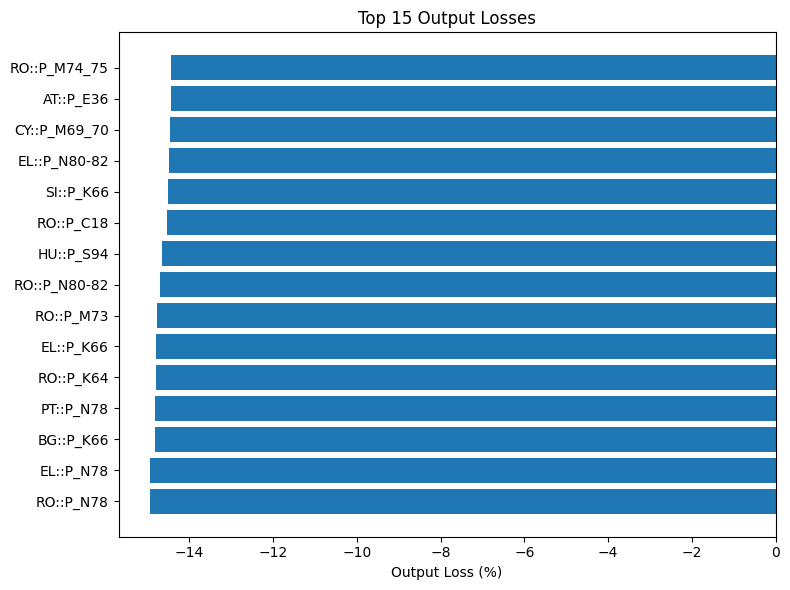

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.barh(df_loss_sorted["node"][:15], df_loss_sorted["loss_pct"][:15])
plt.xlabel("Output Loss (%)")
plt.title("Top 15 Output Losses")
plt.tight_layout()
plt.show()


In [10]:
df_demand = pd.DataFrame({
    "node": node_labels,
    "FD_post": FD_post,
    "FD_implied": FD_implied,
    "delta": FD_implied - FD_post
})

df_demand.head(10)

,node,FD_post,FD_implied,delta
0,AT::P_A01,1530.351741,1530.351741,-2.273737e-13
1,AT::P_A02,185.827586,185.827586,-1.421085e-13
2,AT::P_A03,30.584769,30.584769,3.552714e-15
3,AT::P_B,1636.897533,1636.897533,0.000000e+00
4,AT::P_C10-12,11572.408864,11572.408864,0.000000e+00
5,AT::P_C13-15,1116.374740,1116.374740,2.273737e-13
6,AT::P_C16,2506.799562,2506.799562,0.000000e+00
7,AT::P_C17,1549.970326,1549.970326,0.000000e+00
8,AT::P_C18,289.566012,289.566012,5.684342e-14
9,AT::P_C19,1564.605678,1564.605678,4.547474e-13
